In [1]:
!pip install torch transformers datasets spacy matplotlib seqeval

In [2]:
!pip install evaluate

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.4 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [38]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertForSequenceClassification, BertTokenizerFast,
    GPT2LMHeadModel, GPT2TokenizerFast,
    T5ForConditionalGeneration, T5TokenizerFast,
    Trainer, TrainingArguments, get_linear_schedule_with_warmup,
    DataCollatorWithPadding, DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq, AutoTokenizer, 
    AutoModelForTokenClassification, pipeline, DataCollatorForTokenClassification,
    AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, 
)
from datasets import load_dataset, DatasetDict
import spacy
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import os
import random
from torch.optim import AdamW
import evaluate
import json
import argparse

In [50]:
%%bash
cat > fine_tune.py << 'EOF'


import argparse
import torch
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    AutoModelForSeq2SeqLM,
    DataCollatorWithPadding,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments
)


def fine_tune(args):
    ds = load_dataset(args.dataset, args.dataset_config) if args.dataset_config else load_dataset(args.dataset)
    train_split = ds.get('train')
    eval_split  = ds.get('validation') or ds.get('test')

    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    if args.task in ['seq-classification']:
        model = AutoModelForSequenceClassification.from_pretrained(args.model_name, num_labels=args.num_labels)
        data_collator = DataCollatorWithPadding(tokenizer)
    elif args.task in ['token-classification']:
        model = AutoModelForTokenClassification.from_pretrained(args.model_name, num_labels=args.num_labels)
        data_collator = DataCollatorWithPadding(tokenizer)
    elif args.task in ['seq2seq']:
        model = AutoModelForSeq2SeqLM.from_pretrained(args.model_name)
        data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    else:
        raise ValueError("Unsupported task")

    def preprocess_fn(batch):
        if args.task == 'seq-classification':
            return tokenizer(batch[args.text_column],
                             truncation=True,
                             padding='max_length',
                             max_length=args.max_length)
        elif args.task == 'token-classification':
            tokenized = tokenizer(batch[args.text_column], is_split_into_words=True,
                                  truncation=True, padding='max_length', max_length=args.max_length)
            labels = []
            for i, word_ids in enumerate(tokenized.word_ids(batch_index=i) for i in range(len(batch[args.label_column]))):
                word_ids = word_ids
                prev = None; label_ids = []
                for wid in word_ids:
                    if wid is None:
                        label_ids.append(-100)
                    elif wid != prev:
                        label_ids.append(batch[args.label_column][i][wid])
                    else:
                        label_ids.append(-100)
                    prev = wid
                labels.append(label_ids)
            tokenized["labels"] = labels
            return tokenized
        elif args.task == 'seq2seq':
            inputs = tokenizer(batch[args.text_column], truncation=True, padding='max_length', max_length=args.max_length)
            targets = tokenizer(batch[args.summary_column], truncation=True,
                                padding='max_length', max_length=args.target_length)
            inputs["labels"] = targets["input_ids"]
            return inputs

    cols_to_remove = [c for c in ds['train'].column_names if c not in [args.text_column, args.label_column, args.summary_column]]
    tokenized = ds.map(preprocess_fn, batched=True, remove_columns=cols_to_remove)

    training_args = TrainingArguments(
        output_dir=args.output_dir,
        num_train_epochs=args.epochs,
        per_device_train_batch_size=args.train_bs,
        per_device_eval_batch_size=args.eval_bs,
        learning_rate=args.lr,
        save_strategy="epoch",
        logging_steps=args.log_steps,
        no_cuda=False,
        fp16=True,
        logging_strategy="steps",
        disable_tqdm=False,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized['train'],
        eval_dataset=tokenized['validation'] if 'validation' in tokenized else tokenized['test'],
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    trainer.train()
    print(trainer.evaluate())

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Fine-tune HF Transformer")
    parser.add_argument("--model_name", type=str, required=True)
    parser.add_argument("--dataset", type=str, required=True)
    parser.add_argument("--dataset_config", type=str, default=None)
    parser.add_argument("--task", choices=["seq-classification","token-classification","seq2seq"], required=True)
    parser.add_argument("--text_column", type=str, default="text")
    parser.add_argument("--label_column", type=str, default="label")
    parser.add_argument("--summary_column", type=str, default="summary")
    parser.add_argument("--num_labels", type=int, default=2)
    parser.add_argument("--max_length", type=int, default=128)
    parser.add_argument("--target_length", type=int, default=64)
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_bs", type=int, default=16)
    parser.add_argument("--eval_bs", type=int, default=32)
    parser.add_argument("--lr", type=float, default=5e-5)
    parser.add_argument("--log_steps", type=int, default=50)
    parser.add_argument("--output_dir", type=str, default="./fine_tuned")
    args = parser.parse_args()
    fine_tune(args)
EOF

In [6]:
raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(5000))
small_test  = raw["test"].shuffle(seed=42).select(range(1000))
datasets = DatasetDict({"train": small_train, "test": small_test})
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
max_length = 128
def tokenize_fn(batch):
    return tokenizer(batch["text"],
                     padding="max_length",
                     truncation=True,
                     max_length=max_length)
tokenized = datasets.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch",
                     columns=["input_ids", "attention_mask", "label"])
train_loader = DataLoader(tokenized["train"],
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)
test_loader  = DataLoader(tokenized["test"],
                          batch_size=32,
                          shuffle=False,
                          pin_memory=True)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 157, Test batches: 32


In [7]:
vocab_size = tokenizer.vocab_size
embed_dim  = 128
hidden_dim = 128
num_heads  = 4
ff_dim     = 256
num_layers = 2
num_classes = 2

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)                   
        _, (h_n, _) = self.lstm(x)                      
        logits = self.classifier(h_n[-1])               
        return logits

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes, max_len=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.pos_encoding[:, :input_ids.size(1), :]
        # Create padding mask for Transformer
        src_key_padding_mask = attention_mask == 0 if attention_mask is not None else None
        enc = self.encoder(x, src_key_padding_mask=src_key_padding_mask) 
        pooled = enc.mean(dim=1)                                         
        logits = self.classifier(pooled)                                 
        return logits

rnn_model = RNNClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
trans_model = TransformerClassifier(vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes).to(device)

print("RNN model:", rnn_model)
print("Transformer model:", trans_model)

RNN model: RNNClassifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)
Transformer model: TransformerClassifier(
  (embedding): Embedding(30522, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, o

In [8]:
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, total_correct / total

def eval_model(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, total_correct / total

rnn_opt = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
trans_opt = torch.optim.Adam(trans_model.parameters(), lr=1e-3)

for name, model, opt in [("RNN", rnn_model, rnn_opt), 
                         ("Transformer", trans_model, trans_opt)]:
    start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, opt, device)
    val_loss, val_acc = eval_model(model, test_loader, device)
    elapsed = time.time() - start
    print(f"{name} → "
          f"Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

RNN → Train loss: 0.6958, Acc: 0.5128 | Val loss: 0.6885, Acc: 0.5470 | Time: 1.2s
Transformer → Train loss: 0.6526, Acc: 0.6172 | Val loss: 0.5578, Acc: 0.7100 | Time: 1.8s


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/5
  RNN: Train Acc 0.5724, Val Acc 0.5640, Train Loss 0.6785, Val Loss 0.6853
  Transformer: Train Acc 0.7644, Val Acc 0.7700, Train Loss 0.4789, Val Loss 0.4828
Epoch 2/5
  RNN: Train Acc 0.6660, Val Acc 0.6000, Train Loss 0.6086, Val Loss 0.7062
  Transformer: Train Acc 0.8526, Val Acc 0.7660, Train Loss 0.3334, Val Loss 0.5204
Epoch 3/5
  RNN: Train Acc 0.7588, Val Acc 0.6010, Train Loss 0.4941, Val Loss 0.7376
  Transformer: Train Acc 0.9212, Val Acc 0.7700, Train Loss 0.2072, Val Loss 0.5588
Epoch 4/5
  RNN: Train Acc 0.8392, Val Acc 0.6120, Train Loss 0.3474, Val Loss 0.8956
  Transformer: Train Acc 0.9628, Val Acc 0.7570, Train Loss 0.1101, Val Loss 0.7829
Epoch 5/5
  RNN: Train Acc 0.9028, Val Acc 0.6160, Train Loss 0.2110, Val Loss 1.1709
  Transformer: Train Acc 0.9828, Val Acc 0.7620, Train Loss 0.0546, Val Loss 0.9947


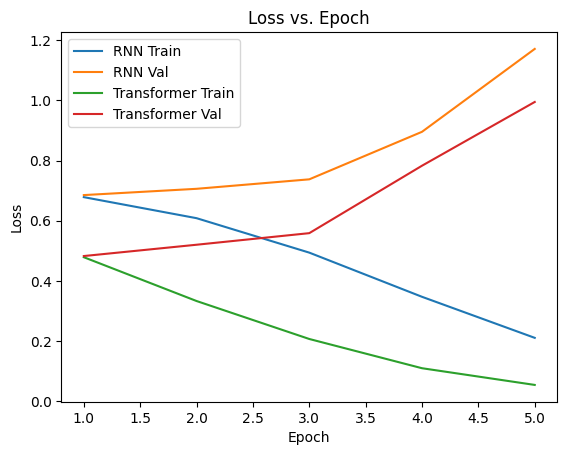

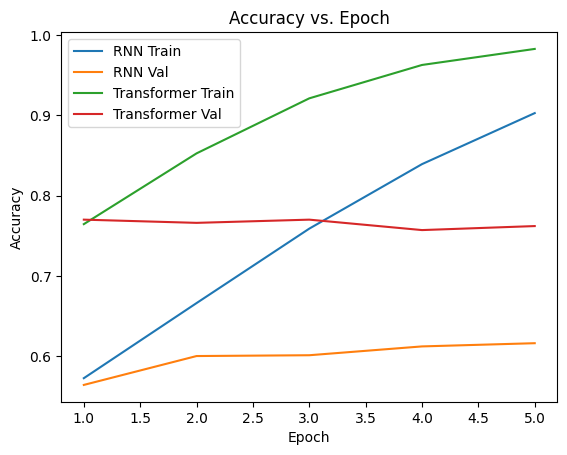

In [9]:
epochs = 5

metrics = {
    "RNN": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []},
    "Transformer": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
}

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    for name, model, optimizer in [
        ("RNN", rnn_model, rnn_opt),
        ("Transformer", trans_model, trans_opt)
    ]:
        t_loss, t_acc = train_epoch(model, train_loader, optimizer, device)
        v_loss, v_acc = eval_model(model, test_loader, device)
        metrics[name]["train_loss"].append(t_loss)
        metrics[name]["val_loss"].append(v_loss)
        metrics[name]["train_acc"].append(t_acc)
        metrics[name]["val_acc"].append(v_acc)
        print(f"  {name}: Train Acc {t_acc:.4f}, Val Acc {v_acc:.4f}, Train Loss {t_loss:.4f}, Val Loss {v_loss:.4f}")

plt.figure()
for name in metrics:
    plt.plot(range(1, epochs+1), metrics[name]["train_loss"], label=f"{name} Train")
    plt.plot(range(1, epochs+1), metrics[name]["val_loss"],   label=f"{name} Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

plt.figure()
for name in metrics:
    plt.plot(range(1, epochs+1), metrics[name]["train_acc"], label=f"{name} Train")
    plt.plot(range(1, epochs+1), metrics[name]["val_acc"],   label=f"{name} Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()

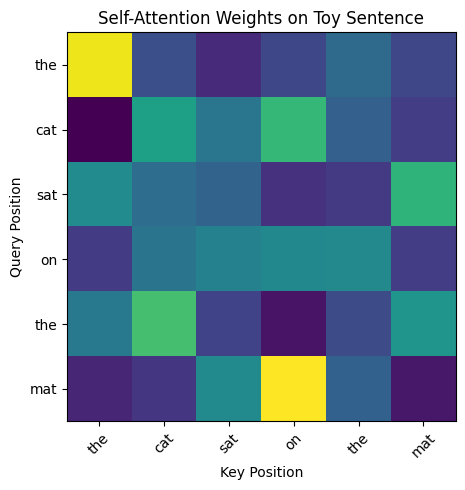

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** -0.5

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale 
        weights = F.softmax(scores, dim=-1)                        
        out = torch.matmul(weights, V)                             
        return out, weights

tokens = ["the", "cat", "sat", "on", "the", "mat"]
seq_len = len(tokens)
embed_dim = 16

torch.manual_seed(42)
x = torch.randn(1, seq_len, embed_dim).to(device)

attn = SelfAttention(embed_dim).to(device)
_, weights = attn(x)

weights = weights[0].cpu().detach().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(weights)
plt.xticks(range(seq_len), tokens, rotation=45)
plt.yticks(range(seq_len), tokens)
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Self-Attention Weights on Toy Sentence")
plt.tight_layout()
plt.show()

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0)) 

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask=None):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=padding_mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

In [12]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim,
                 num_layers, num_classes, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, max_len)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)           
        x = self.pos_encoding(x)                
        padding_mask = (attention_mask == 0) if attention_mask is not None else None
        for layer in self.layers:
            x = layer(x, padding_mask)
        pooled = x.mean(dim=1)                    
        return self.classifier(pooled) 

In [13]:
model = TransformerClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=256,
    num_heads=8,
    ff_dim=512,
    num_layers=4,
    num_classes=2,
    dropout=0.2,
).to(device)

epochs = 8
total_steps = len(train_loader) * epochs
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch}/{epochs} — "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/8 — Train Loss: 0.7058, Acc: 0.5320 | Val Loss: 0.6265, Acc: 0.6440
Epoch 2/8 — Train Loss: 0.6288, Acc: 0.6454 | Val Loss: 0.5641, Acc: 0.6970
Epoch 3/8 — Train Loss: 0.5271, Acc: 0.7270 | Val Loss: 0.5290, Acc: 0.7450
Epoch 4/8 — Train Loss: 0.4387, Acc: 0.7940 | Val Loss: 0.5511, Acc: 0.7110
Epoch 5/8 — Train Loss: 0.3446, Acc: 0.8484 | Val Loss: 0.5528, Acc: 0.7600
Epoch 6/8 — Train Loss: 0.2342, Acc: 0.9066 | Val Loss: 0.6696, Acc: 0.7450
Epoch 7/8 — Train Loss: 0.1543, Acc: 0.9448 | Val Loss: 0.8157, Acc: 0.7620
Epoch 8/8 — Train Loss: 0.0990, Acc: 0.9698 | Val Loss: 0.8756, Acc: 0.7600


In [19]:
raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(2000))
small_test  = raw["test"].shuffle(seed=42).select(range(500))

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_enc = small_train.map(preprocess, batched=True)
test_enc  = small_test.map(preprocess, batched=True)
for ds in (train_enc, test_enc):
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])

data_collator = DataCollatorWithPadding(tokenizer)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)

training_args = TrainingArguments(
    output_dir="bert_finetune",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    logging_steps=50,
    disable_tqdm=False,
    report_to=[],
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    data_collator=data_collator,
)

trainer.train()

print(trainer.evaluate())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.655200
100,0.425500
150,0.292400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.38294684886932373, 'eval_runtime': 2.2131, 'eval_samples_per_second': 225.932, 'eval_steps_per_second': 3.615, 'epoch': 3.0}


In [21]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    return tokenizer(examples["text"], return_special_tokens_mask=True)

tokenized = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"]
)

block_size = 128
def group_texts(examples):
    concatenated = sum(examples["input_ids"], [])
    total_length = len(concatenated) // block_size * block_size
    result = [
        concatenated[i : i + block_size]
        for i in range(0, total_length, block_size)
    ]
    return {"input_ids": result}

lm_dataset = tokenized["train"].map(
    group_texts,
    batched=True,
    remove_columns=tokenized["train"].column_names
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

training_args = TrainingArguments(
    output_dir="./gpt2_finetune",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    disable_tqdm=False,
    report_to=[],
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


/tmp/ipykernel_228/294494369.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,1.926000
200,1.833300
300,1.792200
400,1.791800
500,1.772400
600,1.755500
700,1.739200
800,1.733200
900,1.735200
1000,1.728300


TrainOutput(global_step=2920, training_loss=1.7227352808599603, metrics={'train_runtime': 1857.5897, 'train_samples_per_second': 50.245, 'train_steps_per_second': 1.572, 'total_flos': 6096922951680000.0, 'train_loss': 1.7227352808599603, 'epoch': 5.0})

In [24]:
raw = load_dataset("xsum")
small_train = raw["train"].shuffle(seed=42).select(range(2000))
small_val   = raw["validation"].shuffle(seed=42).select(range(500))

tokenizer = T5TokenizerFast.from_pretrained("t5-small")
max_input_length = 256
max_target_length = 64

def preprocess(batch):
    inputs = tokenizer(
        batch["document"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    targets = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_target_length
    )
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"],
    }

train_enc = small_train.map(preprocess, batched=True, remove_columns=["document","summary"])
val_enc   = small_val.map(preprocess,   batched=True, remove_columns=["document","summary"])
for ds in (train_enc, val_enc):
    ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

data_collator = DataCollatorForSeq2Seq(tokenizer, model="t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

training_args = TrainingArguments(
    output_dir="./t5_summarization",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    save_strategy="no",
    learning_rate=5e-5,
    logging_steps=50,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    disable_tqdm=False,
    report_to=[],
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()
print(trainer.evaluate())

/tmp/ipykernel_228/1616606648.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; 

Step,Training Loss
50,6.346400
100,1.982900
150,1.583400
200,1.496000
250,1.484300
300,1.435200
350,1.464100
400,1.453100
450,1.421500
500,1.420700


{'eval_loss': 1.3295941352844238, 'eval_runtime': 2.5243, 'eval_samples_per_second': 198.073, 'eval_steps_per_second': 6.338, 'epoch': 5.0}


In [25]:
nlp = spacy.load("en_core_web_sm")

text = "Apple is unveiling their new iPhone Operating system in coming June as always."

doc = nlp(text)
print("spaCy NER Results:")
for ent in doc.ents:
    print(f"  {ent.text:20} → {ent.label_}")

spaCy NER Results:
  Apple                → ORG
  coming June          → DATE


In [26]:
tokenizer_ner = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model_ner     = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

ner_pipeline = pipeline(
    "ner",
    model=model_ner,
    tokenizer=tokenizer_ner,
    aggregation_strategy="simple"
)

print("\nTransformer (BERT) NER Results:")
for ent in ner_pipeline(text):
    print(f"  {ent['word']:20} → {ent['entity_group']} ({ent['score']:.2f})")

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Transformer (BERT) NER Results:
  Apple                → ORG (1.00)
  iPhone Operating system → MISC (0.86)


In [27]:
pos_text = "The quick brown fox jumps over the lazy dog."
doc_pos = nlp(pos_text)
print("\nspaCy POS Tagging:")
for token in doc_pos:
    print(f"  {token.text:10} → {token.pos_}")


spaCy POS Tagging:
  The        → DET
  quick      → ADJ
  brown      → ADJ
  fox        → NOUN
  jumps      → VERB
  over       → ADP
  the        → DET
  lazy       → ADJ
  dog        → NOUN
  .          → PUNCT


In [28]:
tokenizer_pos = AutoTokenizer.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
model_pos     = AutoModelForTokenClassification.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")

pos_pipeline = pipeline(
    "token-classification",
    model=model_pos,
    tokenizer=tokenizer_pos,
    aggregation_strategy="simple"
)

print("\nTransformer (BERT) POS Tagging:")
for tok in pos_pipeline(pos_text):
    print(f"  {tok['word']:10} → {tok['entity_group']} ({tok['score']:.2f})")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Transformer (BERT) POS Tagging:
  the        → DET (1.00)
  quick brown → ADJ (0.97)
  fox        → NOUN (1.00)
  jumps      → VERB (1.00)
  over       → ADP (1.00)
  the        → DET (1.00)
  lazy       → ADJ (1.00)
  dog        → NOUN (1.00)
  .          → PUNCT (1.00)


In [30]:
datasets = load_dataset("conll2003")
label_list = datasets["train"].features["ner_tags"].feature.names

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_list)
)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], is_split_into_words=True,
        truncation=True, padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(
    tokenize_and_align_labels, batched=True, remove_columns=datasets["train"].column_names
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_labels = [
        [label_list[l] for l in lab if l != -100]
        for lab in labels
    ]
    true_preds = [
        [label_list[p] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labels)
    ]
    results = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

training_args = TrainingArguments(
    output_dir="./conll2003-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    disable_tqdm=False,
    report_to=[]
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("CoNLL-2003 NER results:", metrics)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

/tmp/ipykernel_228/4271088527.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.137600
1000,0.030100


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


CoNLL-2003 NER results: {'eval_loss': 0.0396127849817276, 'eval_precision': 0.9391959798994974, 'eval_recall': 0.9445754716981132, 'eval_f1': 0.9418780446833528, 'eval_accuracy': 0.9903552013717047, 'eval_runtime': 15.4099, 'eval_samples_per_second': 210.904, 'eval_steps_per_second': 3.31, 'epoch': 3.0}


In [31]:
raw_train = load_dataset("conll2003")["train"]
raw_val   = load_dataset("conll2003")["validation"]

def dump(split, raw_split, filename):
    records = []
    for tokens, tags in zip(raw_split["tokens"], raw_split["ner_tags"]):
        records.append({"tokens": tokens, "ner_tags": tags})
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)

dump("train", raw_train,      "train.json")
dump("validation", raw_val,   "validation.json")

raw_custom = load_dataset("json", data_files={
    "train": "train.json",
    "validation": "validation.json"
})

custom_tokenized = raw_custom.map(
    tokenize_and_align_labels, batched=True, remove_columns=raw_custom["train"].column_names
)

trainer_custom = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_tokenized["train"],
    eval_dataset=custom_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer_custom.train()
print("Custom NER results:", trainer_custom.evaluate())

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

/tmp/ipykernel_228/1715425542.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_custom = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.015300
1000,0.011600


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Custom NER results: {'eval_loss': 0.07605885714292526, 'eval_precision': 0.9446858288770054, 'eval_recall': 0.9523247978436657, 'eval_f1': 0.948489932885906, 'eval_accuracy': 0.9912320012470043, 'eval_runtime': 15.1452, 'eval_samples_per_second': 214.59, 'eval_steps_per_second': 3.367, 'epoch': 3.0}


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

raw = load_dataset("imdb")
small_train = raw["train"].shuffle(seed=42).select(range(5000))
small_test  = raw["test"].shuffle(seed=42).select(range(1000))

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
max_len = 128

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

train_enc = small_train.map(preprocess, batched=True)
test_enc  = small_test.map(preprocess, batched=True)
for ds in (train_enc, test_enc):
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [34]:
class IMDBDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings)
    def __getitem__(self, idx):
        item = {key: self.encodings[idx][key] for key in ["input_ids", "attention_mask"]}
        item["labels"] = self.encodings[idx]["label"]
        return item

train_ds = IMDBDataset(train_enc)
test_ds  = IMDBDataset(test_enc)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=data_collator)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=data_collator)

class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        lengths = attention_mask.sum(dim=1)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # use mean pooling
        mask = attention_mask.unsqueeze(-1)
        pooled = (out * mask).sum(1) / mask.sum(1)
        logits = self.fc(self.dropout(pooled))
        return logits

vocab_size = tokenizer.vocab_size
lstm_model = LSTMSentiment(vocab_size).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [35]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_acc, total = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_acc += (preds == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
        total += labels.size(0)
    return total_loss/total, total_acc/total

def eval_model(model, loader):
    model.eval()
    total_loss, total_acc, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_acc += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total += labels.size(0)
    return total_loss/total, total_acc/total

print("Training LSTM...")
for epoch in range(1, 4):
    t_loss, t_acc = train_epoch(lstm_model, train_loader, optimizer)
    v_loss, v_acc = eval_model(lstm_model, test_loader)
    print(f"Epoch {epoch} | Train Acc: {t_acc:.4f}, Val Acc: {v_acc:.4f}")

Training LSTM...
Epoch 1 | Train Acc: 0.6094, Val Acc: 0.6560
Epoch 2 | Train Acc: 0.7556, Val Acc: 0.7380
Epoch 3 | Train Acc: 0.8480, Val Acc: 0.7750


In [37]:
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)

training_args = TrainingArguments(
    output_dir="bert_sentiment",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_steps=50,
    no_cuda=False,
    fp16=True,
    logging_strategy="steps",
    disable_tqdm=False,
    report_to=[]
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("Fine-tuning BERT...")
trainer.train()
bert_metrics = trainer.evaluate()
print("BERT eval metrics:", bert_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_228/473859987.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fine-tuning BERT...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.574000
100,0.433100
150,0.388100
200,0.268000
250,0.259000
300,0.256700
350,0.189200
400,0.161100
450,0.177200


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


BERT eval metrics: {'eval_loss': 0.4061671197414398, 'eval_runtime': 4.7109, 'eval_samples_per_second': 212.275, 'eval_steps_per_second': 3.396, 'epoch': 3.0}


In [51]:
%%bash
python fine_tune.py \
  --model_name bert-base-uncased \
  --dataset imdb \
  --task seq-classification \
  --text_column text \
  --label_column label \
  --num_labels 2 \
  --epochs 3 \
  --train_bs 16 \
  --eval_bs 32 \
  --lr 2e-5 \
  --log_steps 50 \
  --output_dir ./bert_imdb


{'loss': 0.5703, 'grad_norm': 531634.9375, 'learning_rate': 1.958226768968457e-05, 'epoch': 0.06}
{'loss': 0.3907, 'grad_norm': 428345.25, 'learning_rate': 1.915601023017903e-05, 'epoch': 0.13}
{'loss': 0.3783, 'grad_norm': 345864.15625, 'learning_rate': 1.872975277067349e-05, 'epoch': 0.19}
{'loss': 0.3216, 'grad_norm': 426067.53125, 'learning_rate': 1.8303495311167946e-05, 'epoch': 0.26}
{'loss': 0.3201, 'grad_norm': 449746.03125, 'learning_rate': 1.7877237851662406e-05, 'epoch': 0.32}
{'loss': 0.3518, 'grad_norm': 253256.359375, 'learning_rate': 1.7450980392156866e-05, 'epoch': 0.38}
{'loss': 0.3285, 'grad_norm': 376388.6875, 'learning_rate': 1.7024722932651322e-05, 'epoch': 0.45}
{'loss': 0.3274, 'grad_norm': 604925.125, 'learning_rate': 1.6598465473145782e-05, 'epoch': 0.51}
{'loss': 0.3103, 'grad_norm': 242329.0, 'learning_rate': 1.6172208013640242e-05, 'epoch': 0.58}
{'loss': 0.3074, 'grad_norm': 320835.5, 'learning_rate': 1.5745950554134698e-05, 'epoch': 0.64}
{'loss': 0.2977, 

2025-05-04 12:04:53.462697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746360293.485008    8587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746360293.491918    8587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 50000/50000 [00:45<00:00, 1098.26 examples/s]
/kaggle/working/fine_tune.py:86: FutureWarning: `tokenizer` is deprecated an

In [52]:
%%bash
python fine_tune.py \
  --model_name bert-base-cased \
  --dataset conll2003 \
  --task token-classification \
  --text_column tokens \
  --label_column ner_tags \
  --num_labels 9 \
  --max_length 128 \
  --epochs 3 \
  --train_bs 16 \
  --eval_bs 32 \
  --lr 2e-5 \
  --log_steps 50 \
  --output_dir ./bert_conll


{'loss': 0.7234, 'grad_norm': 77983.6015625, 'learning_rate': 1.9255884586180714e-05, 'epoch': 0.11}
{'loss': 0.1848, 'grad_norm': 94187.2578125, 'learning_rate': 1.8496583143507973e-05, 'epoch': 0.23}
{'loss': 0.1124, 'grad_norm': 90963.6328125, 'learning_rate': 1.7737281700835235e-05, 'epoch': 0.34}
{'loss': 0.0772, 'grad_norm': 104761.8515625, 'learning_rate': 1.697798025816249e-05, 'epoch': 0.46}
{'loss': 0.0758, 'grad_norm': 64836.07421875, 'learning_rate': 1.621867881548975e-05, 'epoch': 0.57}
{'loss': 0.0591, 'grad_norm': 75273.5, 'learning_rate': 1.5459377372817012e-05, 'epoch': 0.68}
{'loss': 0.0591, 'grad_norm': 80091.078125, 'learning_rate': 1.4700075930144269e-05, 'epoch': 0.8}
{'loss': 0.0523, 'grad_norm': 132584.25, 'learning_rate': 1.3940774487471526e-05, 'epoch': 0.91}
{'loss': 0.049, 'grad_norm': 73078.15625, 'learning_rate': 1.3181473044798787e-05, 'epoch': 1.03}
{'loss': 0.0349, 'grad_norm': 114968.859375, 'learning_rate': 1.2422171602126046e-05, 'epoch': 1.14}
{'los

2025-05-04 12:27:36.691643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746361656.714268   14103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746361656.722101   14103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3453/3453 [00:00<00:00, 5158.56 examples/s]
/kaggle/working/fine_tune.py:86: FutureWarning: `tokenizer` is deprecated and will 

CalledProcessError: Command 'b'python fine_tune.py \\\n  --model_name bert-base-cased \\\n  --dataset conll2003 \\\n  --task token-classification \\\n  --text_column tokens \\\n  --label_column ner_tags \\\n  --num_labels 9 \\\n  --max_length 128 \\\n  --epochs 3 \\\n  --train_bs 16 \\\n  --eval_bs 32 \\\n  --lr 2e-5 \\\n  --log_steps 50 \\\n  --output_dir ./bert_conll\n'' returned non-zero exit status 1.